# Project: 멋진 챗봇 만들기

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import sentencepiece as spm
import nltk
import gensim
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

import re
import os
import random
import math

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

print(np.__version__)
print(pd.__version__)
print(tf.__version__)
print(nltk.__version__)
print(gensim.__version__)

1.21.4
1.3.3
2.6.0
3.6.5
3.8.3


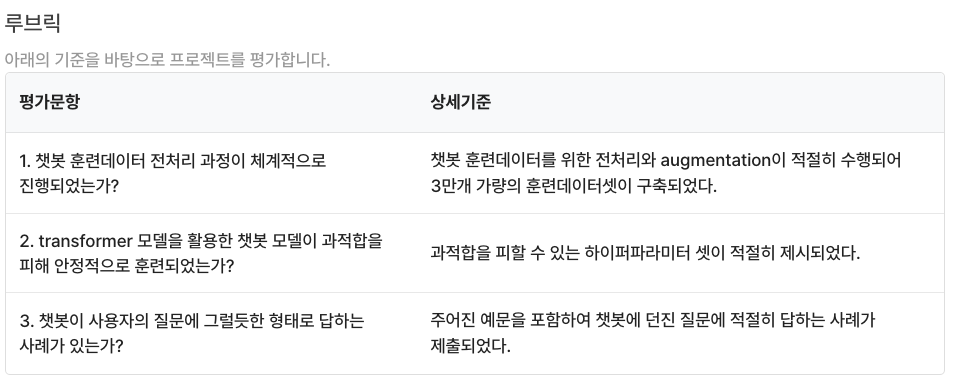

## Step 1. 데이터 다운로드

https://github.com/songys/Chatbot_data

In [39]:
# !wget https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv

In [40]:
df = pd.read_csv('ChatbotData.csv.1')

In [41]:
df.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11823 entries, 0 to 11822
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Q       11823 non-null  object
 1   A       11823 non-null  object
 2   label   11823 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 277.2+ KB


In [43]:
df.describe(include = 'O')

,Q,A
count,11823,11823
unique,11662,7779
top,외로워,맛있게 드세요.
freq,4,22


Q
최대 char 길이 : 
56
최소 char 길이 :
1
평균 char 길이 : 
12


<AxesSubplot:>

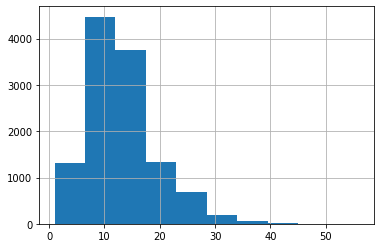

In [44]:
print('Q')
print('최대 char 길이 : ')
print(max(df['Q'].apply(lambda x: len(x))))
print('최소 char 길이 :')
print(min(df['Q'].apply(lambda x: len(x))))
print('평균 char 길이 : ')
print(int(np.mean(df['Q'].apply(lambda x: len(x)))))
df['Q'].apply(lambda x: len(x)).hist()

A
최대 char 길이 : 
76
최소 char 길이 : 
1
평균 char 길이 :
15


<AxesSubplot:>

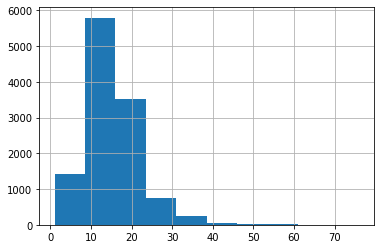

In [45]:
print('A')
print('최대 char 길이 : ')
print(max( df['A'].apply(lambda x: len(x))))
print('최소 char 길이 : ')
print(min( df['A'].apply(lambda x: len(x))))
print('평균 char 길이 :')
print(int(np.mean( df['A'].apply(lambda x: len(x)))))
df['A'].apply(lambda x: len(x)).hist()

## Step 2. 데이터 정제

In [46]:
def preprocess_sentence(sentence):
    sentence = sentence.lower()
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^ㄱ-ㅎ가-힣a-zA-Z!.,?0-9]+", " ", sentence)
    sentence = sentence.strip()
    return sentence

print("슝=3")

슝=3


## Step 3. 데이터 토큰화

In [47]:
from konlpy.tag import Mecab

In [67]:
mecab = Mecab()

In [49]:
questions = df['Q'].values
answers = df['A'].values

- 소스 문장 데이터와 타겟 문장 데이터를 입력으로 받습니다.
- 데이터를 앞서 정의한 preprocess_sentence() 함수로 정제하고, 토큰화합니다.
- 토큰화는 전달받은 토크나이즈 함수를 사용합니다. 이번엔 mecab.morphs 함수를 전달하시면 됩니다.
- 토큰의 개수가 일정 길이 이상인 문장은 데이터에서 제외합니다.
- 중복되는 문장은 데이터에서 제외합니다. 
- 소스 : 타겟 쌍을 비교하지 않고 소스는 소스대로 타겟은 타겟대로 검사합니다. 중복 쌍이 흐트러지지 않도록 유의하세요!

In [74]:
def build_corpus(src, tgt, tokenizer, max_len= 50) :
    
    temp_corpus = list(set(src + '\t' + tgt)) #중복 제거
    
    src_corpus, tgt_corpus = list(), list()
    
    for sen in temp_corpus :
        src_sen, tgt_sen = sen.split('\t')
        
        #src
        src_sen = preprocess_sentence(src_sen) # 전처리
        src_sen = tokenizer.morphs(src_sen) # 형태소 토크나이

        tgt_sen = preprocess_sentence(tgt_sen)
        tgt_sen = tokenizer.morphs(tgt_sen)
        
        if len(src_sen) < max_len and len(tgt_sen) < max_len :
            src_corpus.append(' '.join(src_sen))
            tgt_corpus.append(' '.join(tgt_sen))
        
    assert len(src_corpus) == len(tgt_corpus)   
    
    return src_corpus, tgt_corpus

In [75]:
#build_corpus function 사용하기
question_corpus, answer_corpus = build_corpus(questions, answers, mecab, max_len = 50)

In [76]:
print(len(question_corpus))
print(len(answer_corpus ))

11750
11750


In [77]:
# questions corpus test
question_corpus[0]

'오늘 도 짝사랑 하 는 사람 을 만나 러 갑니다'

In [78]:
# answer corpus test
answer_corpus[0]

'짝사랑 은 언제나 설렘 과 공허 함 을 안겨 줘요 . 부디 설레 길 바랄게요 .'

## Step 4. Augmentation

In [79]:
from gensim.models import KeyedVectors, Word2Vec
from gensim.test.utils import datapath

In [80]:
w2vpath = os.getenv('HOME') + "/aiffel/project_folder/ko.bin"

In [81]:
wv = Word2Vec.load(w2vpath) # gensim version 4.0 이하로 다시 설치함 ; pip install -upgrade gensim==3.8.3

In [82]:
wv.most_similar("엄마")#test sim

/tmp/ipykernel_490/3574220924.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  wv.most_similar("엄마")#test sim


[('아빠', 0.8578546643257141),
 ('아가씨', 0.7076528072357178),
 ('하녀', 0.7051166892051697),
 ('언니', 0.7047619223594666),
 ('친구', 0.7044110298156738),
 ('아저씨', 0.7022912502288818),
 ('강아지', 0.6934334635734558),
 ('할머니', 0.663257360458374),
 ('아기', 0.6483575701713562),
 ('아내', 0.648257851600647)]

In [83]:
def lexical_sub(sentence, word2vec):
    res = ""
    toks = mecab.morphs(sentence)

    try:
        _from = random.choice(toks)
        _to = word2vec.most_similar(_from)[0][0]
        
    except:   # 단어장에 없는 단어
        return None

    for tok in toks:
        if tok is _from: res += _to + " "
        else: res += tok + " "

    return res

In [84]:
sentence = '엄마와 함께 밥먹으로 갔다'
res = lexical_sub(sentence, wv)
print(res)

아빠 와 함께 밥 먹 으로 갔 다 


/tmp/ipykernel_490/1266076471.py:7: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  _to = word2vec.most_similar(_from)[0][0]


In [91]:
for old_src,old_tgt in tqdm(zip(question_corpus[:2], answer_corpus[:2])):
    print(old_src)
    print(old_tgt)

0it [00:00, ?it/s]

오늘 도 짝사랑 하 는 사람 을 만나 러 갑니다
짝사랑 은 언제나 설렘 과 공허 함 을 안겨 줘요 . 부디 설레 길 바랄게요 .
퇴근길 에 봤 네
우연히 마주쳤 군요 .


In [93]:
new_corpus = []

for old_src, old_tgt in tqdm(zip(question_corpus, answer_corpus)):
    new_src = lexical_sub(old_src, wv)
    if new_src is not None: 
        new_corpus.append(new_src +'\t'+ old_tgt)
    # Augmentation이 없더라도 원본 문장을 포함시킵니다
    new_corpus.append(old_src +'\t'+ old_tgt)


for old_tgt, old_src in tqdm(zip(answer_corpus,question_corpus)):
    new_tgt = lexical_sub(old_tgt, wv)
    if new_tgt is not None: 
        new_corpus.append(old_src + '\t' + new_tgt)
    # Augmentation이 없더라도 원본 문장을 포함시킵니다
    new_corpus.append(old_src + '\t' + old_tgt)

0it [00:00, ?it/s]

/tmp/ipykernel_490/1266076471.py:7: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  _to = word2vec.most_similar(_from)[0][0]


0it [00:00, ?it/s]

In [103]:
new_corpus = list(set(new_corpus))

## Step 5. 데이터 벡터화

In [107]:
q_corpus = []
a_corpus = []

for i in new_corpus : 
    q,a = i.split('\t') #separate again into question and answer corpus
    q_corpus.append(q)
    a_corpus.append(a)

In [108]:
#add special tokens to ans corpus

a_corpus = ['<start> ' + i + ' <end>' for i in a_corpus]
print(a_corpus[0])

<start> 강제 계산 당한 거 같 아요 .  <end>


In [113]:
#train and test set separation 5% test

test_size = int(len(a_corpus) * 0.05)

In [118]:
train_q = q_corpus[:-test_size]
test_q = q_corpus[-test_size:]
train_a = a_corpus[:-test_size]
test_a = a_corpus[-test_size:]

In [119]:
len(test_q)

1604

In [127]:
# generate tokenizer
tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
tokenizer.fit_on_texts(q_corpus + a_corpus)

In [129]:
# creat seq tokens
enc_tensor = tokenizer.texts_to_sequences(train_q)
dec_tensor = tokenizer.texts_to_sequences(train_a)

In [133]:
enc_tensor =  tf.keras.preprocessing.sequence.pad_sequences(enc_tensor, maxlen=50, padding='post')
dec_tensor =  tf.keras.preprocessing.sequence.pad_sequences(dec_tensor, maxlen=50, padding='post')

In [135]:
BATCH_SIZE = 64
train_dataset = tf.data.Dataset.from_tensor_slices((enc_tensor, dec_tensor)).batch(batch_size=BATCH_SIZE)

## Step 6. 훈련하기

## 모델 구현하기

In [136]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, (2*(i//2)) / np.float32(d_model))

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])

    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])

    return sinusoid_table

In [137]:
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_lookahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_enc_mask = generate_padding_mask(src)

    dec_lookahead_mask = generate_lookahead_mask(tgt.shape[1])
    dec_tgt_padding_mask = generate_padding_mask(tgt)
    dec_mask = tf.maximum(dec_tgt_padding_mask, dec_lookahead_mask)

    return enc_mask, dec_enc_mask, dec_mask

In [138]:

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        self.depth = d_model // self.num_heads
        
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
        

    def split_heads(self, x):
        bsz = x.shape[0]
        split_x = tf.reshape(x, (bsz, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        bsz = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (bsz, -1, self.d_model))

        return combined_x

    
    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
        
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
                        
        out = self.combine_heads(out)
        out = self.linear(out)
            
        return out, attention_weights

In [139]:

class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.d_model = d_model
        self.d_ff = d_ff

        self.fc1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.fc2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.fc1(x)
        out = self.fc2(out)
            
        return out

In [140]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        '''
        Multi-Head Attention
        '''
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.do(out)
        out += residual
        
        '''
        Position-Wise Feed Forward Network
        '''
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual
        
        return out, enc_attn

In [141]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, dec_enc_mask, padding_mask):
        '''
        Masked Multi-Head Attention
        '''
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.do(out)
        out += residual

        '''
        Multi-Head Attention
        '''
        residual = out
        out = self.norm_2(out)
        # Q, K, V 순서에 주의하세요!
        out, dec_enc_attn = self.enc_dec_attn(Q=out, K=enc_out, V=enc_out, mask=dec_enc_mask)
        out = self.do(out)
        out += residual
        
        '''
        Position-Wise Feed Forward Network
        '''
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, dec_attn, dec_enc_attn

In [142]:
class Encoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
    
        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

In [143]:
class Decoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
    def call(self, x, enc_out, dec_enc_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, dec_enc_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

In [144]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared_fc=True,
                    shared_emb=False):
        super(Transformer, self).__init__()
        
        self.d_model = tf.cast(d_model, tf.float32)

        if shared_emb:
            self.enc_emb = self.dec_emb = \
            tf.keras.layers.Embedding(src_vocab_size, d_model)
        else:
            self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
            self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.do = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared_fc = shared_fc

        if shared_fc:
            self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]

        out = emb(x)

        if self.shared_fc: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.do(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, dec_enc_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, dec_enc_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

In [148]:
# VOCAB_SIZE 
VOCAB_SIZE = len(tokenizer.index_word)

In [149]:
transformer = Transformer(
    n_layers=2,
    d_model=512,
    n_heads=8,
    d_ff=2048,
    src_vocab_size=VOCAB_SIZE,
    tgt_vocab_size=VOCAB_SIZE,
    pos_len=200,
    dropout=0.3,
    shared_fc=True,
    shared_emb=True)
d_model = 512

In [150]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

In [151]:
learning_rate = LearningRateScheduler(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate,
                                        beta_1=0.9,
                                        beta_2=0.98, 
                                        epsilon=1e-9)

In [152]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [153]:
@tf.function()
def train_step(src, tgt, model, optimizer):
    tgt_in = tgt[:, :-1]  # Decoder의 input
    gold = tgt[:, 1:]     # Decoder의 output과 비교하기 위해 right shift를 통해 생성한 최종 타겟

    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt_in)

    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt_in, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, enc_attns, dec_attns, dec_enc_attns

In [155]:
ckpt = tf.train.Checkpoint(step = tf.Variable(1), optimizer = optimizer , transformer = transformer)
manager = tf.train.CheckpointManager(ckpt, './tf_ckpts_gd12',max_to_keep=3)

In [156]:
def train_and_checkpoint(transformer, manager, EPOCH = 2):
    ckpt.restore(manager.latest_checkpoint)
    if manager.latest_checkpoint:
        print("Restored from {}".format(manager.latest_checkpoint))
    
    else:
        print("Initializing from scratch.")

    
    for epoch in range(EPOCH):
        ckpt.step.assign_add(1)
        total_loss = 0

        total_loss = 0

        dataset_count = tf.data.experimental.cardinality(train_dataset).numpy()
        tqdm_bar = tqdm(total=dataset_count)
        for step, (enc_batch, dec_batch) in enumerate(train_dataset):
            batch_loss, enc_attns, dec_attns, dec_enc_attns = \
            train_step(enc_batch,
                        dec_batch,
                        transformer,
                        optimizer)

            total_loss += batch_loss

            tqdm_bar.set_description_str('Epoch %2d' % (epoch + 1))
            tqdm_bar.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (step + 1)))
            tqdm_bar.update()
            
        if int(ckpt.step) % 2 == 0:
            save_path = manager.save()
            print("Saved checkpoint for step {}: {}".format(int(ckpt.step), save_path))

In [157]:
train_and_checkpoint(transformer, manager, EPOCH = 3)

Initializing from scratch.


  0%|          | 0/477 [00:00<?, ?it/s]

Saved checkpoint for step 2: ./tf_ckpts_gd12/ckpt-1


  0%|          | 0/477 [00:00<?, ?it/s]

  0%|          | 0/477 [00:00<?, ?it/s]

Saved checkpoint for step 4: ./tf_ckpts_gd12/ckpt-2


## Step 7. 성능 측정하기

In [178]:
def translate(tokens, model, src_tokenizer, tgt_tokenizer):
    tokens = mecab.morphs(tokens)
    tokens = tokenizer.texts_to_sequences(tokens)
    padded_tokens = tf.keras.preprocessing.sequence.pad_sequences(tokens,
                                                           maxlen=50,
                                                           padding='post')
    ids = []
    output = tf.expand_dims([tokenizer.word_index['<start>']], 0)   
    for i in range(50):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(padded_tokens, output)

        predictions, _, _, _ = model(padded_tokens, 
                                      output,
                                      enc_padding_mask,
                                      combined_mask,
                                      dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tokenizer.word_index['<end>'] == predicted_id:
            result = ' '.join([tgt_tokenizer.index_word[i] for i in ids if i != 0])  
            return result

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = ' '.join([tgt_tokenizer.index_word[i] for i in ids if i != 0])  
    return result

print("슝=3")

슝=3


In [191]:
# examples :

examples = [
    '짝사랑 너무 힘들어요',
    '배고파서 힘들다',
    '나랑 같이 놀자',
    '여행가고 싶어요',
    '스트레스 받고 있어요'
]

for i,example in enumerate(examples):
    
    print(f'quesions {i+1}:',example)
    print(f'reponse {i+1}:', translate(example, transformer, tokenizer, tokenizer))
    print()

quesions 1: 짝사랑 너무 힘들어요
reponse 1: 그래도 사랑 이 행복 해질 거 예요 .

quesions 2: 배고파서 힘들다
reponse 2: 맛난 거 드세요 .

quesions 3: 나랑 같이 놀자
reponse 3: 궁금 해 보 세요 .

quesions 4: 여행가고 싶어요
reponse 4: 안 좋 은 여행 이 모두 가 되 죠 .

quesions 5: 스트레스 받고 있어요
reponse 5: 진정 시키 는 소리 를 버리 세요 .



In [197]:
def beam_search_decoder(sentence, 
                        src_len,
                        tgt_len,
                        model,
                        src_tokenizer,
                        tgt_tokenizer,
                        beam_size):
    
    sentence = mecab.morphs(sentence)
    
    def calc_prob(src_ids, tgt_ids, model):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(src_ids, tgt_ids)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(src_ids, 
                tgt_ids,
                enc_padding_mask,
                combined_mask,
                dec_padding_mask)

        return tf.math.softmax(predictions, axis=-1)
    
    tokens = src_tokenizer.texts_to_sequences(sentence)
    
    src_in = tf.keras.preprocessing.sequence.pad_sequences(tokens,
                                                            maxlen=src_len,
                                                            padding='post')

    pred_cache = np.zeros((beam_size * beam_size, tgt_len), dtype=np.int64)
    pred_tmp = np.zeros((beam_size, tgt_len), dtype=np.int64)

    eos_flag = np.zeros((beam_size, ), dtype=np.int64)
    scores = np.ones((beam_size, ))

    pred_tmp[:, 0] = tgt_tokenizer.word_index['<start>']

    dec_in = tf.expand_dims(pred_tmp[0, :1], 0)
    prob = calc_prob(src_in, dec_in, model)[0, -1].numpy()

    for seq_pos in range(1, tgt_len):
        score_cache = np.ones((beam_size * beam_size, ))

        # init
        for branch_idx in range(beam_size):
            cache_pos = branch_idx*beam_size

            score_cache[cache_pos:cache_pos+beam_size] = scores[branch_idx]
            pred_cache[cache_pos:cache_pos+beam_size, :seq_pos] = \
            pred_tmp[branch_idx, :seq_pos]

        for branch_idx in range(beam_size):
            cache_pos = branch_idx*beam_size

            if seq_pos != 1:   # 모든 Branch를 로 시작하는 경우를 방지
                dec_in = pred_cache[branch_idx, :seq_pos]
                dec_in = tf.expand_dims(dec_in, 0)

                prob = calc_prob(src_in, dec_in, model)[0, -1].numpy()

            for beam_idx in range(beam_size):
                max_idx = np.argmax(prob)

                score_cache[cache_pos+beam_idx] *= prob[max_idx]
                pred_cache[cache_pos+beam_idx, seq_pos] = max_idx

                prob[max_idx] = -1

        for beam_idx in range(beam_size):
            if eos_flag[beam_idx] == -1: continue

            max_idx = np.argmax(score_cache)
            prediction = pred_cache[max_idx, :seq_pos+1]

            pred_tmp[beam_idx, :seq_pos+1] = prediction
            scores[beam_idx] = score_cache[max_idx]
            score_cache[max_idx] = -1

            if prediction[-1] == tgt_tokenizer.word_index['<end>']:
                eos_flag[beam_idx] = -1

    pred = []
    for long_pred in pred_tmp:
        zero_idx = long_pred.tolist().index(tgt_tokenizer.word_index['<end>'])
        short_pred = long_pred[:zero_idx+1]
        pred.append(short_pred)
        
    return  [' '.join([src_tokenizer.index_word[j] for j in i]) for i in pred]

In [199]:
MAX_LEN= 50

for i, example in enumerate(examples) :
    print(f'quesions {i+1}:',example)
    print(f'response {i+1}:', beam_search_decoder(example,
                        MAX_LEN,
                        MAX_LEN,
                        transformer,
                        tokenizer,
                        tokenizer,
                        beam_size=3))
    print()

quesions 1: 짝사랑 너무 힘들어요
response 1: ['<start> 그래도 사랑 이 행복 해질 거 예요 . <end>', '<start> 그래도 사랑 해질 행복 해질 거 예요 . <end>', '<start> 그래도 행복 이 행복 해질 거 예요 . <end>']

quesions 2: 배고파서 힘들다
response 2: ['<start> 맛난 거 드세요 . <end>', '<start> 맛난 거 드세요 는데 <end>', '<start> 맛난 것 드세요 . <end>']

quesions 3: 나랑 같이 놀자
response 3: ['<start> 궁금 해 보 세요 . <end>', '<start> 궁금 하 보 세요 . <end>', '<start> 제 해 보 세요 . <end>']

quesions 4: 여행가고 싶어요
response 4: ['<start> 안 좋 은 여행 이 모두 가 되 죠 . <end>', '<start> 안 좋 은 여행 가 모두 가 되 죠 . <end>', '<start> 안 좋 은 여행 이 모두 가 되 는 . <end>']

quesions 5: 스트레스 받고 있어요
response 5: ['<start> 진정 시키 는 소리 를 버리 세요 . <end>', '<start> 나쁜 시키 는 소리 를 버리 세요 . <end>', '<start> 진정 이 는 소리 를 버리 세요 . <end>']



### evaluate transformer

In [231]:
def eval_bleu_single(model, src_sentence, tgt_sentence, src_tokenizer, tgt_tokenizer, verbose=True):
    src_tokens = tokenizer.texts_to_sequences(src_sentence)
    tgt_tokens = tokenizer.texts_to_sequences(tgt_sentence)

    if (len(src_tokens) > MAX_LEN): return None
    if (len(tgt_tokens) > MAX_LEN): return None

    reference = tgt_sentence.split()[1:-1]
    candidate = translate(src_sentence, model, src_tokenizer, tgt_tokenizer).split()

    score = sentence_bleu(reference, candidate,
                          smoothing_function=SmoothingFunction().method1)

    if verbose:
        print("Source Sentence: ", src_sentence)
        print("Model Prediction: ", candidate)
        print("Real: ", reference)
        print("Score: %lf\n" % score)
        
    return score
        
print('슝=3')

슝=3


In [234]:
# 인덱스를 바꿔가며 테스트해 보세요
test_idx = 0

eval_bleu_single(transformer, 
                 test_q[0], 
                 test_a[0], 
                 tokenizer, 
                 tokenizer)

Source Sentence:  날 버려 달 라고
Model Prediction:  ['꾸준히', '해도', '조심', '하', '세요', '.']
Real:  ['슬프', '군요', '.']
Score: 0.040825



0.040824829046386304

In [236]:
def eval_bleu(model, src_sentences, tgt_sentence, src_tokenizer, tgt_tokenizer, verbose=True):
    total_score = 0.0
    sample_size = len(src_sentences)
    
    for idx in tqdm(range(sample_size)):
        score = eval_bleu_single(model, src_sentences[idx], tgt_sentence[idx], src_tokenizer, tgt_tokenizer, verbose)
        if not score: continue
        
        total_score += score
    
    print("Num of Sample:", sample_size)
    print("Total Score:", total_score / sample_size)
    
print("슝=3")

슝=3


In [237]:
eval_bleu(transformer, test_q, test_a, tokenizer, tokenizer, verbose=False)
# 하이퍼파라미터 튜닝을 조근 더 하고 학습 epoch 조금 더 올리면 결과가 좋아 질 것 같다.

  0%|          | 0/1604 [00:00<?, ?it/s]

Num of Sample: 1604
Total Score: 0.03844337461022094
